# Import settings

In [1]:
import kagglehub
import pandas as pd

C:\Users\leeun\PycharmProjects\WeatherProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


download datas from kagglehub.

In [2]:
path = kagglehub.dataset_download("muthuj7/weather-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\leeun\.cache\kagglehub\datasets\muthuj7\weather-dataset\versions\1


Put your printed file result to see if the file loaded.

In [3]:
file_path = r"C:/Users/leeun/.cache/kagglehub/datasets/muthuj7/weather-dataset/versions/1/weatherHistory.csv"

df = pd.read_csv(file_path)
print(df.head())

                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0               1015.13  

Decision Trees (and most ML algorithms) work best with numerical data (typically floats or integers).
We need to adjust string values to any float numbers.

- We'll change Summary as **CloudCoverRate**.
- We'll drop **Date** and **Daily Summary** column. This doesn't need for predicting humidity.
- We'll also drop **Precip type** for easy calculation.

In [4]:
# Define a mapping for cloud cover rate
cloud_cover_mapping = {
    "Clear": 0.0,
    "Partly Cloudy": 0.3,  # You can adjust this
    "Mostly Cloudy": 0.7, # You can adjust this
    "Overcast": 0.85,
    "Foggy": 1.0,  # You can adjust this
}

# Create the 'CloudCoverRate' column using the mapping
df['CloudCoverRate'] = df['Summary'].map(cloud_cover_mapping)

# Verify the new column
print(df[['Summary', 'CloudCoverRate']].head())


         Summary  CloudCoverRate
0  Partly Cloudy             0.3
1  Partly Cloudy             0.3
2  Mostly Cloudy             0.7
3  Partly Cloudy             0.3
4  Mostly Cloudy             0.7


# Train the Datas
We'll predict **humidity** based on other given datas. so **formatted date** is unuseful.

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Humidity', 'Formatted Date', 'Precip Type', 'Daily Summary', 'Summary'])
y = df['Humidity']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Train a Decision Tree Regressor
tree_clf = DecisionTreeRegressor(max_depth=50)
tree_clf.fit(X_train, y_train) # Fit the model to training data

# Make predictions on the test set
y_pred = tree_clf.predict(X_test)

Evaluate the Decision Tree

In [6]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Evaluate the model using metrics appropriate for regression
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Calculate RMSE
mae = mean_absolute_error(y_test, y_pred) # Calculate MAE
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Print the predicted and actual results for a subset of test data
print("\nPredicted vs Actual Values (First 10):")
for i in range(min(10, len(y_test))):
    print(f"Predicted: {y_pred[i]:.4f}, Actual: {y_test.iloc[i]:.4f}")


Mean Squared Error (MSE): 0.0189
Root Mean Squared Error (RMSE): 0.1375
Mean Absolute Error (MAE): 0.0936
R-squared (R2): 0.5038

Predicted vs Actual Values (First 10):
Predicted: 0.9600, Actual: 0.8700
Predicted: 0.3700, Actual: 0.6200
Predicted: 0.6100, Actual: 0.5900
Predicted: 0.8200, Actual: 0.6300
Predicted: 0.8100, Actual: 0.7800
Predicted: 0.3100, Actual: 0.3100
Predicted: 0.7000, Actual: 0.8600
Predicted: 0.8400, Actual: 0.6600
Predicted: 0.5400, Actual: 0.5300
Predicted: 0.5400, Actual: 0.5300


Visualize the result.

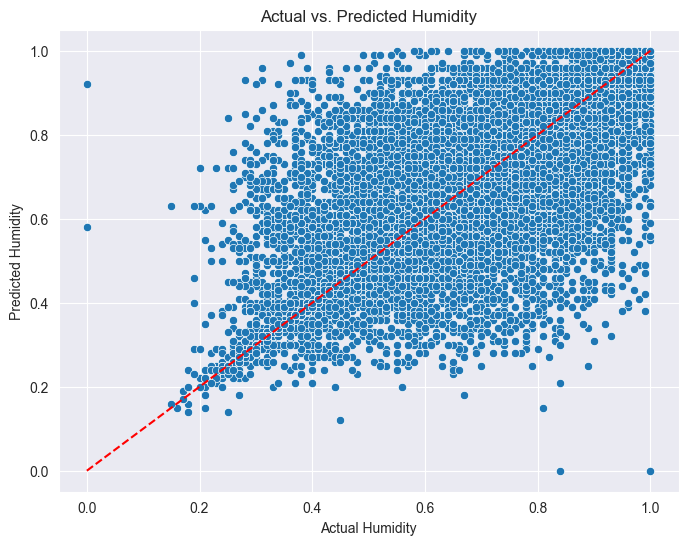

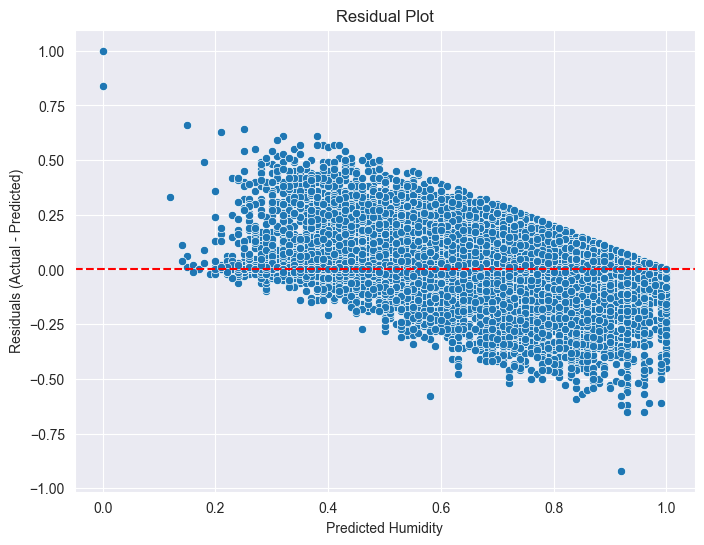

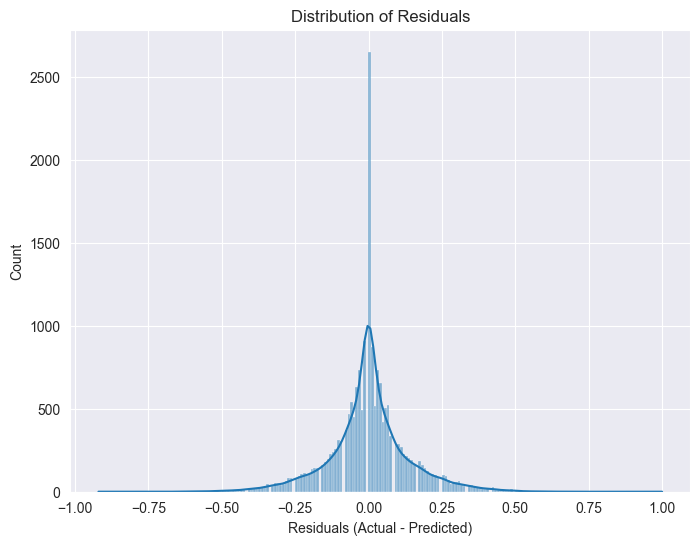

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Scatter Plot of Predicted vs. Actual Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Humidity")
plt.ylabel("Predicted Humidity")
plt.title("Actual vs. Predicted Humidity")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') # Add diagonal line
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Humidity")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

# 3. Distribution Plot of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Distribution of Residuals")
plt.show()

# **Understanding the Metrics**

*   **Mean Squared Error (MSE): 0.0189:**
    *   This is the average of the squared differences between your predicted and actual humidity values.
    *   The lower the MSE, the better.
    *   **Interpretation:** Because it is squared, it's not in the same units as the humidity, which is between 0 and 1. It's difficult to intuitively understand the magnitude of an MSE. We can say that the smaller the value, the better the performance, but we can not know how good or bad the model is based on this value. We mostly use this for comparing models.

*   **Root Mean Squared Error (RMSE): 0.1375:**
    *   The square root of the MSE. It's in the same unit as your humidity, making it easier to interpret (in this case, humidity is in the range of 0 to 1).
    *   **Interpretation:**  On average, your model's predictions are about 0.1375 away from the true humidity values. Since humidity is a percentage (range 0 to 1), 0.1375 would be 13.75%. So there is a 13.75% error on average. This is the most important metric because it is easier to interpret.

*   **Mean Absolute Error (MAE): 0.0936:**
    *   The average of the absolute differences between predicted and actual values.
    *   **Interpretation:** On average, the absolute difference between your model's predictions and the true humidity values is about 0.0936. This is a more robust metric than RMSE, which is less sensitive to outliers. This metric is also on the percentage scale of 0 to 1, so the model makes a 9.36% error on average in magnitude.

*   **R-squared (R2): 0.5038:**
    *   Indicates the proportion of the variance in the humidity that's predictable by your model.
    *   Ranges from -infinity to 1. The higher the R2, the better. 1 means perfect fitting, 0 means your model performs as well as always predicting the mean value, negative value means your model performs worse than always predicting the mean value.
    *   **Interpretation:** About 50.38% of the variance in the humidity data is explained by the features in your model. The other 49.62% of the variance isn't captured by the model.
    *   A common interpretation of 0.5 is that the model is "moderately good" but it is dependent on the business context.

# **Analyzing the Results**

1.  **Error Magnitude:**
    *   An RMSE of 0.1375 and a MAE of 0.0936 tells you that, on average, your predictions have an error of about 9.36 to 13.75%. This is an important number because this is how much the model is wrong on average.
    *   Whether this is "good enough" depends on your specific application. For some scenarios, this error might be too high; for others, it might be acceptable.

2.  **Model Fit:**
    *   An R-squared of 0.5038 indicates that your model explains about half of the variability in the humidity data. This is a moderately good model fit but it can be improved.
    *   If R2 is close to 1, you have a well-fit model, and if R2 is close to 0, it means you may have a poorly-fitted model.
    *   An R-squared of 0.5038 means that you still have an opportunity to improve your model.

3.  **Example Predictions:**
    *   Looking at the first 10 predictions, you see both close predictions (e.g., predicted: 0.54, actual: 0.53) and larger errors (e.g., predicted: 0.37, actual: 0.62).
    *   In this case, the model over-estimates in some cases (predicted is greater than actual) and under-estimates in others.

# **How to Think About Improvements**

## Based on these results:

1.  **Is the Error Acceptable?**
    *   First and foremost, consider whether an RMSE of 0.1375 (or 13.75% error on average) is acceptable for your goal. This is the most important information because it tells the performance of the model in the unit of the target variable. If the goal is to have the model predict humidity with an error of less than 5%, the model needs to be improved.
    *   If not, you will want to reduce this value.

2.  **Feature Engineering:**
    *   Explore more informative features. Consider if there are additional feature transformations that you can do. Can you use date or time to improve the model?

3.  **Model Complexity:**
    *   Try different `max_depth` values of the decision tree to improve the performance, or switch to a different model.
        *   Decision Tree has very high bias and can't capture any complex functions of data.
    *   If the model has too high complexity, it might overfit the model and perform poorly in the test set.

4.  **Data Preprocessing:**
    *   Look for outliers in your data, since the model may have an issue trying to fit to them.
    *   Change cloud cover rate for better result.

5.  **Collect More Data:**
    *   Consider if having more data points can improve the performance.

# **Next Steps**

1.  **Review the Visualizations:** Look at the plots in the earlier response to look for trends in the data and the model.
2.  **Address Outliers:** If you see any outliers, try to fix them with removing or data transformation.
3.  **Experiment with Different Models:** Don't settle for just one model. Try models like Linear Regression, Gradient Boosting, Random Forest and neural networks.
4.  **Regularly Check Test Performance:** When doing model selection or hyper-parameter tunning, make sure to look at the performance of the test set because you can easily overfit the training set and perform poorly in the unseen data.